- Using Apples' M1 ANE as Backend
- intepreter = /Users/itaicohen/.pyenv/versions/torch_nightly/bin/python

In [1]:
import platform
!pyenv which python
print(platform.platform())
!whereis huggingface-cli login

/Users/itaicohen/.pyenv/versions/torch_nightly/bin/python
macOS-12.6-arm64-arm-64bit
huggingface-cli: /Users/itaicohen/.pyenv/versions/torch_nightly/bin/huggingface-cli
login: /usr/bin/login /usr/share/man/man1/login.1


In [2]:
device = "mps"

import os
from PIL import Image, ImageDraw
import cv2
import numpy as np
from IPython.display import HTML
from base64 import b64encode

import torch
from torch import autocast
from torch.nn import functional as F

# difusers v. 0.2.4 !, watch out, there're many modifications in code. 
from diffusers import StableDiffusionPipeline, AutoencoderKL
from diffusers import UNet2DConditionModel, PNDMScheduler, LMSDiscreteScheduler
from diffusers.schedulers.scheduling_ddim import DDIMScheduler
from transformers import CLIPTextModel, CLIPTokenizer
from tqdm.auto import tqdm

#Linear Discrete scheduler(see end of the notebook.)
from scipy import integrate
from typing import Union

# Cifar 10 dataset

In [3]:
import os.path as osp
path = "/Users/itaicohen/Datasets/cifar10/cifar-10-batches-py"
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

!ls $path

c10_data = unpickle(osp.join(path,"data_batch_1"))

batches.meta data_batch_2 data_batch_4 readme.html
data_batch_1 data_batch_3 data_batch_5 test_batch


In [4]:
c10_data.keys()

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])

In [5]:
images = c10_data[b"data"].reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("uint8") # (10000,3072)
labels = c10_data[b"labels"]

# image pertubations

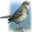

In [227]:
i=np.random.randint(10000)
img = images[i]

img_latents = encode_img_latents([img]) #img2latent space

Image.fromarray(images[i])

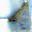

In [228]:
dec_img = decode_img_latents(img_latents)[0]
dec_img

In [229]:
def perturb(latents,sigma=1):
    """adds normal noise to latent representation of an image"""
    return torch.Tensor(np.random.normal(latents.cpu().detach().numpy(),sigma,size=latents.size())).to(device)

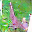

In [222]:
decode_img_latents(perturb(img_latents,sigma=0.1))[0]

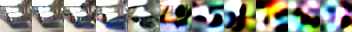

In [242]:
sigmas = [0,0.1,0.2,0.3,0.5,1,2,3,5,10,20]

i=np.random.randint(10000)
img = images[i]

img_latents = encode_img_latents([img]) 

pertub_imgs = [decode_img_latents(perturb(img_latents,sigma=sigma))[0] for sigma in sigmas]

image_grid(pertub_imgs,1,len(pertub_imgs))





# Stable Diffussion - Inference

There are three main components in latent diffusion.

<b> 1.An autoencoder (VAE). </b>

The VAE model has two parts, an encoder and a decoder. The encoder is used to convert the image into a low dimensional latent representation, which will serve as the input to the U-Net model. The decoder, conversely, transforms the latent representation back into an image.

During latent diffusion training, the encoder is used to get the latent representations (latents) of the images for the forward diffusion process, which applies more and more noise at each step. During inference, the denoised latents generated by the reverse diffusion process are converted back into images using the VAE decoder. As we will see during inference we only need the VAE decoder.


<b> 2. A U-Net. </b>

The U-Net has an encoder part and a decoder part both comprised of ResNet blocks. The encoder compresses an image representation into a lower resolution image representation and the decoder decodes the lower resolution image representation back to the original higher resolution image representation that is supposedly less noisy. More specifically, the U-Net output predicts the noise residual which can be used to compute the predicted denoised image representation.

To prevent the U-Net from losing important information while downsampling, short-cut connections are usually added between the downsampling ResNets of the encoder to the upsampling ResNets of the decoder. Additionally, the stable diffusion U-Net is able to condition its output on text-embeddings via cross-attention layers. The cross-attention layers are added to both the encoder and decoder part of the U-Net usually between ResNet blocks.

<b> 3. A text-encoder, e.g. CLIP's Text Encoder. </b>

The text-encoder is responsible for transforming the input prompt, *e.g.* "An astronout riding a horse" into an embedding space that can be understood by the U-Net. It is usually a simple *transformer-based* encoder that maps a sequence of input tokens to a sequence of latent text-embeddings.

<p align="middle">
<img src="https://raw.githubusercontent.com/patrickvonplaten/scientific_images/master/stable_diffusion.png" alt="sd-pipeline" width="500"/>
</p>

# Denoising an Image from Gaussian noise by Diffusion. 

Let $p_{data}(\bf{x})$ be the data distribution, $\sigma_{data}$ it standard deviation. 
Let $p(\bf{x},\sigma)$ be a mollified data distribution by adding the Gaussian noise $\mathcal{N}(0,\sigma)$.

The idea of diffusion models is to go from pure noised image $x_0=\mathcal{N}(0,\sigma_{max})$ into a clean image.

$$\sigma_0=\sigma_{max} > ...>\sigma_N=0; x_t \sim p(x_t ; \sigma). $$

This is a Markovian process with latent states $x_N,...,x_0$, and their transitions probabilities:

The Reverse tranjectory goes from complete noised to the images districution:

$$ p(x_{t+1}|x_{t}) = \mathcal{N}(x_{t+1}; \mu_{\theta}(x_t,t),\Sigma_{\theta}(x_t,t))   $$

The forward tranjectory goes from the image data distribution back to pure indistinguishable noise:

$$ q(x_{t-1}|x_{t}) = \mathcal{N}(x_{t-1}; \sqrt{1-\beta_{t}}x_t,\beta_t ) $$


The image $\bf{x}$ evolution in time $t$ is governed by a probability flow's ODE:
$$
d\mathbf{x}=-\dot{\sigma(t)}\sigma(t)\nabla_x \log p(\mathbf{x};\sigma(t))dt
$$


Training is performed by optimizing the usual variational bound on negative log likelihood. That is going the tranjectory from $p_{data}$ to $p(x_t,\sigma_{max})$ and back to $p_data$. Training by minimizing the usual variational bound on negative log likelihood. 


The expression $\nabla_x \log p(\mathbf{x};\sigma(t))$ is the score function, a vector field that points "away" from the data. It has a remarkable characteristic that it doesn't depends on the normalization constant of $p(x;\sigma)$.

The paper claims that the best solution is for $\sigma(t)=t$, where the PDE decompose to:

$$\frac{dx}{dt}=\frac{x-D(x;t)}{t}.$$







In [8]:
## TODO: - connection to the theory. What is the score function ? How is the derivative computed? 
##       - nummerical analysis. Euler method and its 4th order extention; explicit computation 
##        of the lms cooefficiets .


class LMSDiscreteScheduler_():
    
    """Linear denoising simplified with Euler. """
    def __init__(
        self,
        num_train_timesteps=1000,
        beta_start=0.0001,
        beta_end=0.02,
        beta_schedule="linear",
        trained_betas=None,
        timestep_values=None,
    ):
        """
        Linear Multistep Scheduler for discrete beta schedules. Based on the original k-diffusion implementation by
        Katherine Crowson:
        https://github.com/crowsonkb/k-diffusion/blob/481677d114f6ea445aa009cf5bd7a9cdee909e47/k_diffusion/sampling.py#L181
        """

        if beta_schedule == "linear":
            self.betas = np.linspace(beta_start, beta_end, num_train_timesteps, dtype=np.float32)
        elif beta_schedule == "scaled_linear":
            # this schedule is very specific to the latent diffusion model.
            self.betas = np.linspace(beta_start**0.5, beta_end**0.5, num_train_timesteps, dtype=np.float32) ** 2
        
        self.alphas = 1.0 - self.betas
        self.alphas_cumprod = np.cumprod(self.alphas, axis=0)
        self.sigmas = ((1 - self.alphas_cumprod) / self.alphas_cumprod) ** 0.5

        # setable values
        self.num_train_timesteps = num_train_timesteps
        self.num_inference_steps = None
        self.timesteps = np.arange(0, num_train_timesteps)[::-1].copy()
        self.derivatives = []

    def get_lms_coefficient(self, order, t, current_order):
        
        """
        Compute a linear multistep coefficient
        """

        def lms_derivative(tau):
            prod = 1.0
            for k in range(order): # k=0,1,2,3 #current_order = 0,1,2,3
                if current_order == k: #current_order = 0,1,2,3
                    continue
                prod *= (tau - self.sigmas[t - k]) / (self.sigmas[t - current_order] - self.sigmas[t - k]) #timestep in (0,20)
            return prod
        
        ### (1,2,3) ; current_order=0: (tau-s(t-1))x(tau-s(t-2))x(tau-s(t-3))/((s(t)-s(t-1))x((s(t)-s(t-2))x((s(t)-s(t-3))
        ### (0,2,3) ; current_order=1: (tau-s(t))x(tau-s(t-2))x(tau-s(t-3))/((s(t-1)-s(t))x((s(t-1)-s(t-2))x((s(t-1)-s(t-3))
        
        ### k=0 , current_order=0 ==> 1.0 
        
        
        #integral of the lms_derivative from t to t+1:
        integrated_coeff = integrate.quad(lms_derivative, self.sigmas[t], self.sigmas[t + 1], epsrel=1e-4)[0]

        return integrated_coeff

    def set_timesteps(self, num_inference_steps):
        
        """smoothes the computed sigmas according to num_inference_steps """
        
        self.num_inference_steps = num_inference_steps
        self.timesteps = np.linspace(self.num_train_timesteps - 1, 0, num_inference_steps, dtype=float)

        low_idx = np.floor(self.timesteps).astype(int)
        high_idx = np.ceil(self.timesteps).astype(int)
        frac = np.mod(self.timesteps, 1.0)
        sigmas = np.array(((1 - self.alphas_cumprod) / self.alphas_cumprod) ** 0.5)
        sigmas = (1 - frac) * sigmas[low_idx] + frac * sigmas[high_idx]
        self.sigmas = np.concatenate([sigmas, [0.0]])

        self.derivatives = []

    def step(
        self,
        model_output: Union[torch.FloatTensor, np.ndarray],
        timestep: int,
        sample: Union[torch.FloatTensor, np.ndarray],
        order: int = 4,
        Euler: bool = False
    ):
        sigma = self.sigmas[timestep]

        # 1. compute predicted original sample (x_0) from sigma-scaled predicted noise
        ## pred_original_sample = sample - sigma * model_output

        # 2. Convert to an ODE derivative
        ## derivative = (sample - pred_original_sample) / sigma
        derivative = model_output
        
        self.derivatives.append(derivative)
        if len(self.derivatives) > order:
            self.derivatives.pop(0)
        
        # Numeric approximation. 
        # 3. Compute linear multistep coefficients (comes only from the sigmas)
        if not Euler:
            order = min(timestep + 1, order)# 1,2,3,4,4,4,...
            lms_coeffs = [self.get_lms_coefficient(order, timestep, curr_order) for curr_order in range(order)]
        else:
            order = 1 
            lms_coeffs=[self.sigmas[timestep+1]-self.sigmas[timestep]]
        
        
        # 4. Compute previous sample based on the derivatives path
        if not Euler:
            prev_sample = sample + sum(
                coeff * derivative for coeff, derivative in zip(lms_coeffs, reversed(self.derivatives))
            )
        else:
            prev_sample = sample + model_output*(self.sigmas[timestep+1]-self.sigmas[timestep])

        return {"prev_sample": prev_sample}

    def add_noise(self, original_samples, noise, timesteps):
        alpha_prod = self.alphas_cumprod[timesteps]
        alpha_prod = self.match_shape(alpha_prod, original_samples)

        noisy_samples = (alpha_prod**0.5) * original_samples + ((1 - alpha_prod) ** 0.5) * noise
        return noisy_samples


# Text-To-Image

0it [00:00, ?it/s]

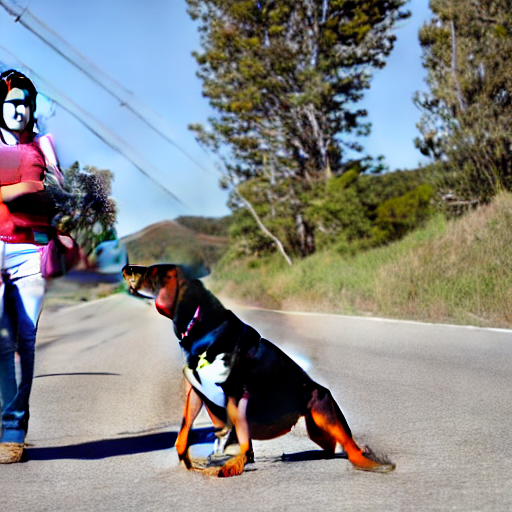

In [9]:
pipe = StableDiffusionPipeline.from_pretrained("./stable-diffusion-v1-4")
pipe = pipe.to(device)

prompt = "Ingrid and her Rottweiler on the road to Salinas."

# Results match those from the CPU device after the warmup pass.
image = pipe(prompt,num_inference_steps=10)["sample"][0]
image

# Expilict examples

In [10]:
# 1. Load the autoencoder model which will be used to decode the latents into image space. 
vae = AutoencoderKL.from_pretrained(
    './stable-diffusion-v1-4', subfolder='vae', use_auth_token=True)
vae = vae.to(device)

# 2. Load the tokenizer and text encoder to tokenize and encode the text. 
tokenizer = CLIPTokenizer.from_pretrained('./clip-vit-large-patch14')
text_encoder = CLIPTextModel.from_pretrained('./clip-vit-large-patch14')
text_encoder = text_encoder.to(device)

# 3. The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained(
    './stable-diffusion-v1-4', subfolder='unet', use_auth_token=True)
unet = unet.to(device)

# 4. Create a scheduler for inference
scheduler = LMSDiscreteScheduler_(
    beta_start=0.00085, beta_end=0.012,
    beta_schedule='scaled_linear', num_train_timesteps=1000)

Some weights of the model checkpoint at ./clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.14.mlp.fc1.bias', 'vision_model.encoder.layers.4.self_attn.q_proj.weight', 'vision_model.encoder.layers.23.self_attn.k_proj.weight', 'vision_model.encoder.layers.7.self_attn.v_proj.bias', 'vision_model.encoder.layers.16.mlp.fc2.bias', 'vision_model.encoder.layers.5.self_attn.v_proj.bias', 'vision_model.encoder.layers.10.self_attn.out_proj.bias', 'vision_model.encoder.layers.1.self_attn.q_proj.bias', 'vision_model.encoder.layers.9.self_attn.k_proj.bias', 'vision_model.encoder.layers.4.self_attn.k_proj.weight', 'vision_model.encoder.layers.17.self_attn.v_proj.weight', 'vision_model.encoder.layers.17.self_attn.v_proj.bias', 'vision_model.encoder.layers.17.self_attn.out_proj.bias', 'vision_model.encoder.layers.19.self_attn.out_proj.bias', 'vision_model.encoder.layers.10.self_attn.k_proj.weight', 'vision_model.encoder.layers.3.layer_norm1.bias', 'visi

<b>A bit about schedulers</b>

In [11]:
#TODO: explicit text embeds.
def get_text_embeds(prompt):
    # Tokenize text and get embeddings
    text_input = tokenizer(
        prompt, padding='max_length', max_length=tokenizer.model_max_length,
        truncation=True, return_tensors='pt')
    with torch.no_grad():
        text_embeddings = text_encoder(text_input.input_ids.to(device))[0]

    # Do the same for unconditional embeddings
    uncond_input = tokenizer(
        [''] * len(prompt), padding='max_length',
        max_length=tokenizer.model_max_length, return_tensors='pt')
    with torch.no_grad():
        uncond_embeddings = text_encoder(uncond_input.input_ids.to(device))[0]

    # Cat for final embeddings
    text_embeddings = torch.cat([uncond_embeddings, text_embeddings])
    return text_embeddings

# test_embeds = get_text_embeds(['cute dog'])
# print(test_embeds)
# print(test_embeds.shape)

In [75]:
def produce_latents(text_embeddings, height=512, width=512,
                    num_inference_steps=50, guidance_scale=7.5, latents=None,
                    return_all_latents=False,Euler=True):
    global Log_Cache_imgs 
    Log_Cache_imgs=[]
    
    #A. normal distribution (pure) noise for the pure noise initial image.
    if latents is None:
        latents = torch.randn((text_embeddings.shape[0] // 2, unet.in_channels, \
                           height // 8, width // 8))
    
    
    latents = latents.to(device)
    scheduler.set_timesteps(num_inference_steps)
    #B. TODO: What's this multiplication for ? sigma is the graditute of noise., going down to zero.
    latents = latents * scheduler.sigmas[0]
    latent_hist = [latents]
    
    with autocast('cpu'):
        for i, t in tqdm(enumerate(scheduler.timesteps)):
            # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
            latent_model_input = torch.cat([latents] * 2)
            sigma = scheduler.sigmas[i]
            
            # Scales the denoising model input by `(sigma**2 + 1) ** 0.5` to match the K-LMS algorithm.
            latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5)

            # predict the noise residual with the unet.
            with torch.no_grad():
                noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)['sample']

            # perform guidance
            ## what does that guidance actualy means ?
            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2) # probabily this refers to the first comment of not doing 2 forward passes.
            noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

            # compute the previous noisy sample x_t -> x_t-1 
            #  Predict the sample at the previous timestep by reversing the SDE.
            # ref: https://github.com/huggingface/diffusers/blob/main/src/diffusers/schedulers/scheduling_lms_discrete.py
            
            ###
            img_pred = latents - scheduler.sigmas[i] * noise_pred
            Log_Cache_imgs.append(img_pred)
            ###
            
            latents = scheduler.step(noise_pred, i, latents,4,Euler=Euler)['prev_sample']
            latent_hist.append(latents)
  
        if not return_all_latents:
            return latents

        all_latents = torch.cat(latent_hist, dim=0)
        return all_latents


def prompt_to_img(prompts, height=512, width=512, num_inference_steps=50,
                  guidance_scale=7.5, latents=None, return_all_latents=False,
                  batch_size=2,Euler=True):
    if isinstance(prompts, str):
        prompts = [prompts]

    # Prompts -> text embeds
    text_embeds = get_text_embeds(prompts)

    # Text embeds -> img latents
    latents = produce_latents(text_embeds, height=height, width=width, latents=latents, num_inference_steps=num_inference_steps, guidance_scale=guidance_scale,return_all_latents=return_all_latents,Euler=Euler) 
  
    # Img latents -> imgs
    all_imgs = []
    for i in tqdm(range(0, len(latents), batch_size)):
        imgs = decode_img_latents(latents[i:i+batch_size])
        all_imgs.extend(imgs)

    return all_imgs

In [98]:
def decode_img_latents(latents):
    latents = 1 / 0.18215 * latents

    with torch.no_grad():
        imgs = vae.decode(latents)

    imgs = (imgs / 2 + 0.5).clamp(0, 1)
    imgs = imgs.detach().cpu().permute(0, 2, 3, 1).numpy()
    imgs = (imgs * 255).round().astype('uint8')
    pil_images = [Image.fromarray(image) for image in imgs]
    return pil_images

def encode_img_latents(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]

    img_arr = np.stack([np.array(img) for img in imgs], axis=0)
    img_arr = img_arr / 255.0
    img_arr = torch.from_numpy(img_arr).float().permute(0, 3, 1, 2) # Batch - RGB channel - WxH 
    img_arr = 2 * (img_arr - 0.5) # values between (-1, 1)

    latent_dists = vae.encode(img_arr.to(device))
    #latent_dists = vae.encode(img_arr)
    
    latent_samples = latent_dists.sample()
    latent_samples *= 0.18215

    return latent_samples



# imgs = decode_img_latents(test_latents)
# imgs[0]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

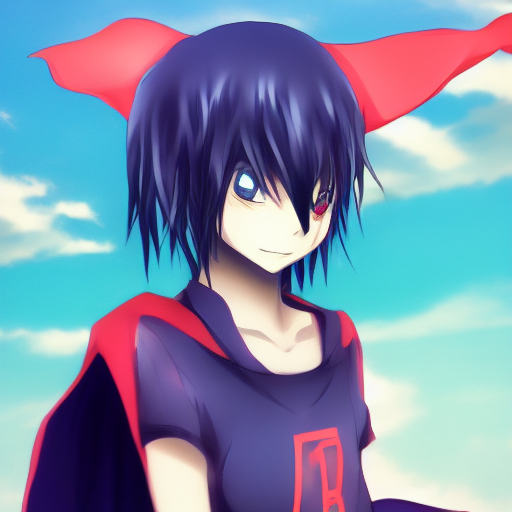

In [14]:
prompt_to_img('Super cool anime character', 512, 512, num_inference_steps=10,Euler=True)[0]

In [15]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

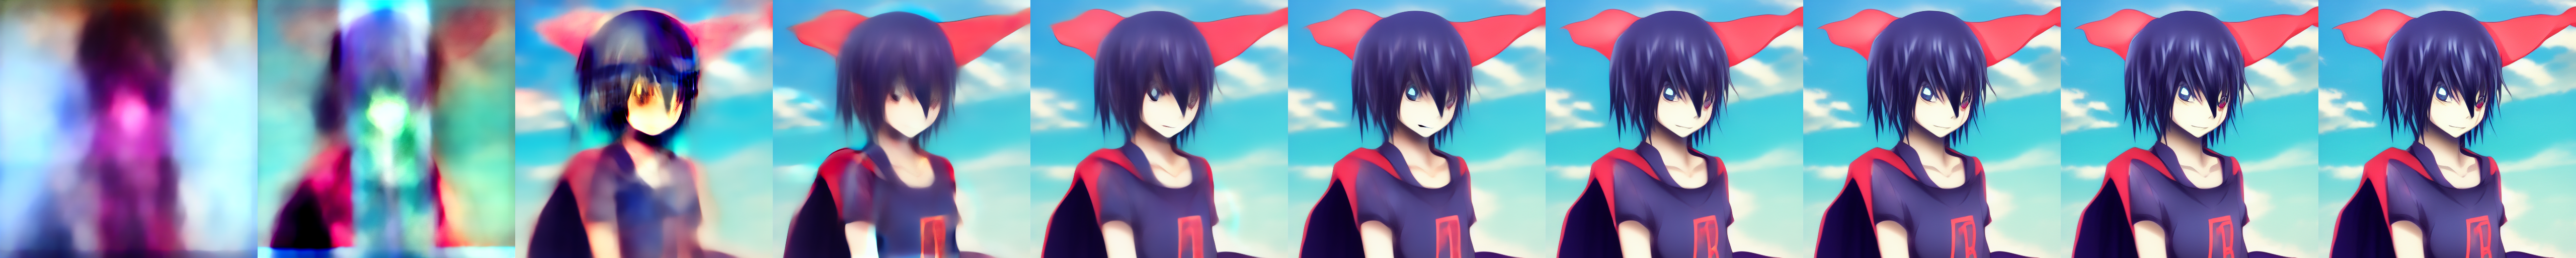

In [16]:
imgs_sequence = [decode_img_latents(Log_Cache_imgs[i])[0] for i in range(len(Log_Cache_imgs))]
image_grid(imgs_sequence,1,len(imgs_sequence))

In [17]:
scheduler.sigmas

array([14.61465549,  7.83988953,  4.60917759,  2.9183085 ,  1.95016205,
        1.34492826,  0.93235815,  0.62497711,  0.36865819,  0.02916753,
        0.        ])

In [18]:
scheduler.timesteps

array([999., 888., 777., 666., 555., 444., 333., 222., 111.,   0.])

# explicit calculation of the linear multistep coefficient from scheduler.step 

In [19]:
#assume order = 1
def get_lms_coefficient(t):
    
    """
    Compute a linear multistep coefficient (first order .)
    """
    integrated_coeff =  scheduler.sigmas[t+1]- scheduler.sigmas[t]

    return integrated_coeff

In [20]:
scheduler.sigmas[5]

1.34492826461792

In [21]:
get_lms_coefficient(9)

-0.029167532920837402

# Make a Video

In [22]:
def imgs_to_video(imgs, video_name='video.mp4', fps=15):
  # Source: https://stackoverflow.com/questions/52414148/turn-pil-images-into-video-on-linux
  video_dims = (imgs[0].width, imgs[0].height)
  fourcc = cv2.VideoWriter_fourcc(*"avc1")    
  video = cv2.VideoWriter(video_name, fourcc, fps, video_dims)
  for img in imgs:
    tmp_img = img.copy()
    video.write(cv2.cvtColor(np.array(tmp_img), cv2.COLOR_RGB2BGR))
  video.release()

def display_video(file_path, width=512):
  compressed_vid_path = 'comp_' + file_path
  if os.path.exists(compressed_vid_path):
    os.remove(compressed_vid_path)
  os.system(f'ffmpeg -i {file_path} -vcodec libx264 {compressed_vid_path}')

  mp4 = open(compressed_vid_path, 'rb').read()
  data_url = 'data:simul2/mp4;base64,' + b64encode(mp4).decode()
  return HTML("""
    <video width={} controls>
          <source src="{}" type="video/mp4">
    </video>
    """.format(width, data_url))

In [23]:
prompt = 'Starry night with a purple sky manga art'
video_frames = prompt_to_img(
    prompt, num_inference_steps=10, return_all_latents=True)

0it [00:00, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [24]:
vid_name = prompt.replace(' ', '_') + '.mp4'
imgs_to_video(video_frames, vid_name)
display_video(vid_name)

ffmpeg version 5.1.2 Copyright (c) 2000-2022 the FFmpeg developers
  built with Apple clang version 14.0.0 (clang-1400.0.29.102)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/5.1.2 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libbluray --enable-libdav1d --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --enable-libsoxr --enable-libzmq --enable-libzimg --disable-libjack --disable-indev=jack --enable-videotoolb

# <b> Similar Img </b>

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

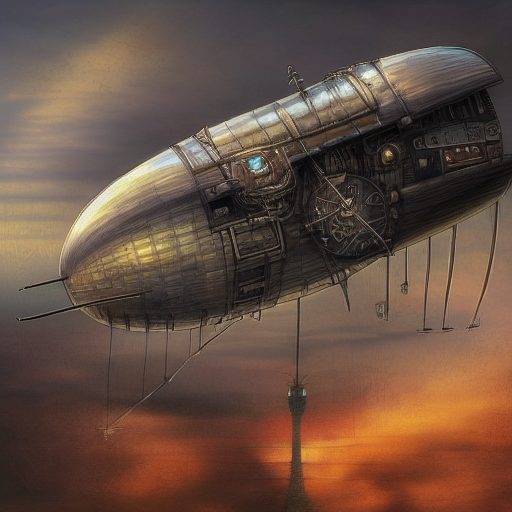

In [25]:
prompt = 'Steampunk airship bursting through the clouds, cyberpunk art'
latents = torch.randn((1, unet.in_channels, 512 // 8, 512 // 8))
img = prompt_to_img(prompt, num_inference_steps=20, latents=latents)[0]
img

In [26]:
def perturb_latents(latents, scale=0.1):
    noise = torch.randn_like(latents)
    new_latents = (1 - scale) * latents + scale * noise
    return (new_latents - new_latents.mean()) / new_latents.std()

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

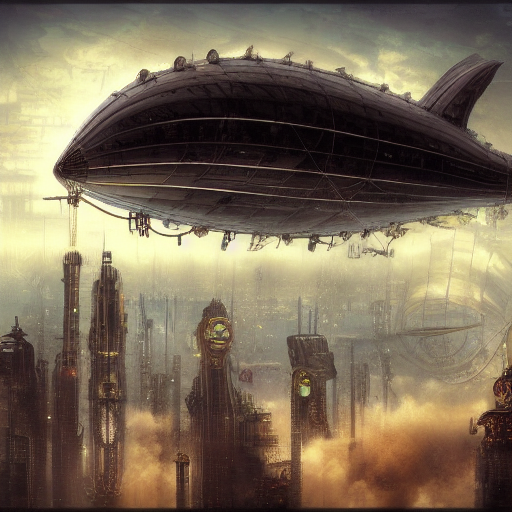

In [27]:
new_latents = perturb_latents(latents, 0.4)
img = prompt_to_img(prompt, num_inference_steps=20, latents=new_latents)[0]
img

# Img to Img (generates a new image from a given text + an image)

In [74]:
scheduler = LMSDiscreteScheduler_(
    beta_start=0.00085, beta_end=0.012,
    beta_schedule='scaled_linear', num_train_timesteps=1000)

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

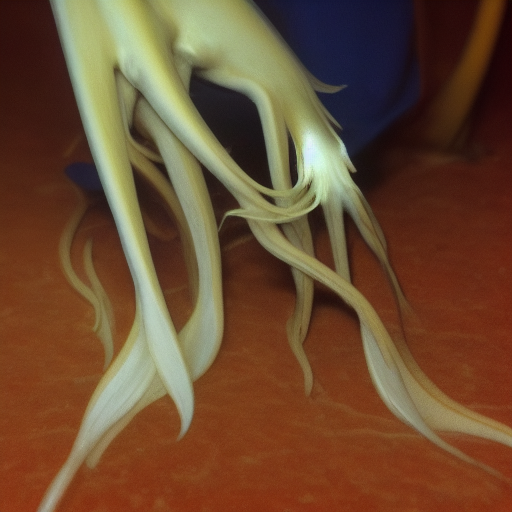

In [76]:
prompt = 'Upright squid'
img = prompt_to_img(prompt, num_inference_steps=10)[0]
img

In [81]:
np.asarray(img)

array([[[ 43,  13,   5],
        [ 43,  15,   6],
        [ 44,  15,   9],
        ...,
        [ 29,   9,   4],
        [ 26,   6,   5],
        [ 26,   9,   0]],

       [[ 45,  15,   9],
        [ 43,  14,   8],
        [ 44,  14,  12],
        ...,
        [ 24,   6,   6],
        [ 18,   4,   4],
        [ 25,   4,   0]],

       [[ 44,  13,  10],
        [ 45,  15,  12],
        [ 43,  12,  12],
        ...,
        [ 26,   6,   5],
        [ 23,   6,   6],
        [ 24,   4,   2]],

       ...,

       [[138,  57,  21],
        [140,  58,  23],
        [142,  62,  26],
        ...,
        [138,  49,  20],
        [138,  49,  19],
        [136,  46,  16]],

       [[138,  54,  23],
        [143,  58,  25],
        [140,  59,  23],
        ...,
        [140,  44,  19],
        [146,  54,  23],
        [142,  51,  18]],

       [[128,  56,  32],
        [138,  58,  26],
        [139,  57,  22],
        ...,
        [142,  50,  22],
        [139,  51,  21],
        [128,  56,  27]]

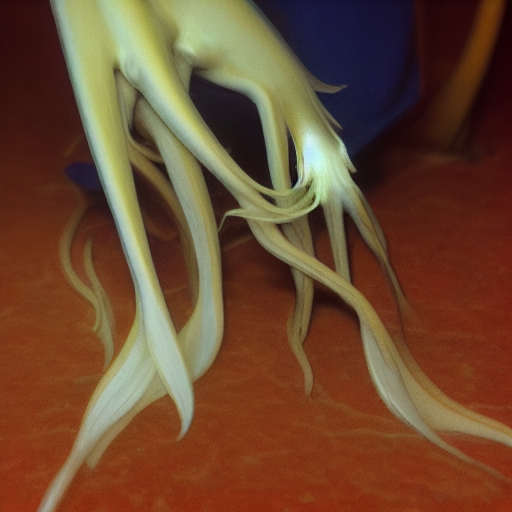

In [83]:
img_latents = encode_img_latents([img])
dec_img = decode_img_latents(img_latents)[0]
dec_img

In [84]:
np.asarray(dec_img)

array([[[ 41,   8,   5],
        [ 39,  10,   5],
        [ 41,  10,   8],
        ...,
        [ 25,   8,   4],
        [ 23,   6,   5],
        [ 27,   9,   0]],

       [[ 42,   9,   7],
        [ 39,   9,   6],
        [ 42,  10,  11],
        ...,
        [ 19,   3,   6],
        [ 16,   3,   4],
        [ 24,   3,   0]],

       [[ 42,   9,   9],
        [ 43,  11,  12],
        [ 40,   7,  11],
        ...,
        [ 21,   4,   5],
        [ 22,   5,   6],
        [ 22,   3,   2]],

       ...,

       [[138,  51,  18],
        [143,  54,  21],
        [143,  55,  22],
        ...,
        [141,  43,  16],
        [143,  43,  15],
        [140,  41,  14]],

       [[139,  50,  21],
        [146,  53,  23],
        [144,  55,  21],
        ...,
        [144,  37,  15],
        [151,  48,  19],
        [143,  45,  15]],

       [[130,  55,  33],
        [140,  53,  23],
        [140,  51,  19],
        ...,
        [145,  45,  19],
        [143,  46,  19],
        [129,  52,  23]]

In [55]:
img_latents

/Users/itaicohen/.pyenv/versions/3.9.5/envs/torch_nightly/lib/python3.9/site-packages/torch/_tensor_str.py:115: UserWarning: The operator 'aten::nonzero' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:11.)
  nonzero_finite_vals = torch.masked_select(


tensor([[[[ 0.8498,  0.4296,  0.7640,  ...,  0.6688,  0.2468,  0.6255],
          [ 0.4496,  0.5920,  0.2096,  ...,  0.5494,  0.7805,  0.6595],
          [ 0.6644,  0.8671,  0.7116,  ...,  0.2958,  0.7384,  0.1616],
          ...,
          [ 0.7324,  0.4662,  0.6687,  ...,  0.0786,  0.3791,  0.5482],
          [ 0.7228,  0.2299,  0.8861,  ...,  0.8901,  0.6730,  0.2972],
          [ 0.4037,  0.6632,  0.3818,  ...,  0.5797,  0.5185,  0.3094]],

         [[ 0.0160,  0.1366,  0.3688,  ...,  0.0730, -0.1124,  0.1460],
          [-0.2523,  0.2246,  0.1834,  ...,  0.0460, -0.0576,  0.1407],
          [ 0.0050,  0.2273,  0.1696,  ..., -0.0036,  0.0443,  0.1796],
          ...,
          [ 0.0396,  0.1179,  0.2498,  ...,  0.3066,  0.0685,  0.1636],
          [ 0.1699, -0.1936,  0.4068,  ...,  0.1527, -0.0708,  0.1020],
          [-0.0652,  0.2663,  0.1328,  ...,  0.0806,  0.1550,  0.0603]],

         [[-0.6232, -0.2264, -0.1208,  ..., -0.3615, -0.4728, -0.0910],
          [-0.5145, -0.3934, -

In [32]:
# New scheduler for img-to-img (Changed the scheduler !)
scheduler = DDIMScheduler(
    beta_start=0.00085, beta_end=0.012,
    beta_schedule='scaled_linear', num_train_timesteps=1000)

In [33]:
def produce_latents(text_embeddings, height=512, width=512,
                    num_inference_steps=50, guidance_scale=7.5, latents=None,
                    return_all_latents=False, start_step=10):
  if latents is None:
    latents = torch.randn((text_embeddings.shape[0] // 2, unet.in_channels, \
                           height // 8, width // 8))
  latents = latents.to(device)

  scheduler.set_timesteps(num_inference_steps)
  if start_step > 0:
    start_timestep = scheduler.timesteps[start_step]
    start_timesteps = start_timestep.repeat(latents.shape[0]).long()

    noise = torch.randn_like(latents)
    latents = scheduler.add_noise(latents, noise, start_timesteps)

  latent_hist = [latents]
  with autocast('cpu'):
    for i, t in tqdm(enumerate(scheduler.timesteps.type(torch.float16)[start_step:])):
      # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
      latent_model_input = torch.cat([latents] * 2)

      # predict the noise residual
      with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)['sample']

      # perform guidance
      noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
      noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

      # compute the previous noisy sample x_t -> x_t-1
      latents = scheduler.step(noise_pred, t.long(), latents)['prev_sample']
      latent_hist.append(latents)
  
  if not return_all_latents:
    return latents

  all_latents = torch.cat(latent_hist, dim=0)
  return all_latents

def prompt_to_img(prompts, height=512, width=512, num_inference_steps=50,
                  guidance_scale=7.5, latents=None, return_all_latents=False,
                  batch_size=2, start_step=0):
  if isinstance(prompts, str):
    prompts = [prompts]

  # Prompts -> text embeds
  text_embeds = get_text_embeds(prompts)

  # Text embeds -> img latents
  latents = produce_latents(
      text_embeds, height=height, width=width, latents=latents,
      num_inference_steps=num_inference_steps, guidance_scale=guidance_scale,
      return_all_latents=return_all_latents, start_step=start_step)
  
  # Img latents -> imgs
  all_imgs = []
  for i in tqdm(range(0, len(latents), batch_size)):
    imgs = decode_img_latents(latents[i:i+batch_size])
    all_imgs.extend(imgs)

  return all_imgs

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

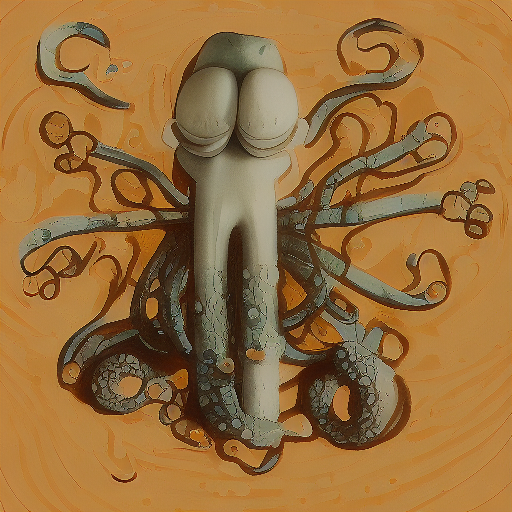

In [34]:
prompt = 'Squidward'
img = prompt_to_img(prompt, num_inference_steps=30, latents=img_latents,
                    start_step=10)[0]
img

In [35]:
## Unfolding the Linear Discrete Schedualer. 

In [36]:
scheduler = LMSDiscreteScheduler_(
    beta_start=0.00085, beta_end=0.012,
    beta_schedule='scaled_linear', num_train_timesteps=50)

In [37]:
scheduler.set_timesteps(20)

In [38]:
scheduler.timesteps

array([49.        , 46.42105263, 43.84210526, 41.26315789, 38.68421053,
       36.10526316, 33.52631579, 30.94736842, 28.36842105, 25.78947368,
       23.21052632, 20.63157895, 18.05263158, 15.47368421, 12.89473684,
       10.31578947,  7.73684211,  5.15789474,  2.57894737,  0.        ])

In [39]:
scheduler.betas

array([0.00085   , 0.00094835, 0.00105209, 0.00116121, 0.00127572,
       0.0013956 , 0.00152088, 0.00165153, 0.00178757, 0.00192899,
       0.00207579, 0.00222798, 0.00238555, 0.0025485 , 0.00271683,
       0.00289055, 0.00306966, 0.00325414, 0.00344401, 0.00363926,
       0.0038399 , 0.00404592, 0.00425732, 0.0044741 , 0.00469627,
       0.00492382, 0.00515675, 0.00539507, 0.00563877, 0.00588786,
       0.00614232, 0.00640217, 0.00666741, 0.00693802, 0.00721402,
       0.00749541, 0.00778217, 0.00807432, 0.00837185, 0.00867477,
       0.00898307, 0.00929675, 0.00961581, 0.00994026, 0.0102701 ,
       0.01060531, 0.01094591, 0.01129189, 0.01164325, 0.012     ],
      dtype=float32)

In [40]:
scheduler.alphas

array([0.99915   , 0.99905163, 0.9989479 , 0.9988388 , 0.9987243 ,
       0.9986044 , 0.9984791 , 0.9983485 , 0.99821246, 0.998071  ,
       0.9979242 , 0.99777204, 0.99761444, 0.9974515 , 0.99728316,
       0.9971095 , 0.99693036, 0.9967459 , 0.996556  , 0.9963607 ,
       0.9961601 , 0.9959541 , 0.9957427 , 0.9955259 , 0.99530375,
       0.9950762 , 0.99484324, 0.99460495, 0.9943612 , 0.99411213,
       0.9938577 , 0.9935978 , 0.99333256, 0.99306196, 0.992786  ,
       0.9925046 , 0.99221784, 0.99192566, 0.99162817, 0.99132526,
       0.9910169 , 0.9907032 , 0.99038416, 0.99005973, 0.9897299 ,
       0.98939466, 0.9890541 , 0.98870814, 0.98835677, 0.988     ],
      dtype=float32)

In [41]:
scheduler.alphas_cumprod

array([0.99915   , 0.99820244, 0.99715227, 0.9959943 , 0.99472374,
       0.99333555, 0.9918248 , 0.9901868 , 0.9884168 , 0.98651016,
       0.9844624 , 0.98226905, 0.9799258 , 0.97742844, 0.97477293,
       0.9719553 , 0.9689717 , 0.9658186 , 0.9624923 , 0.9589895 ,
       0.95530707, 0.951442  , 0.9473914 , 0.94315267, 0.9387234 ,
       0.9341013 , 0.92928433, 0.9242708 , 0.91905904, 0.9136478 ,
       0.9080359 , 0.90222245, 0.8962069 , 0.889989  , 0.88356864,
       0.8769459 , 0.87012136, 0.8630957 , 0.85587   , 0.84844553,
       0.8408239 , 0.8330069 , 0.8249968 , 0.8167961 , 0.80840755,
       0.79983413, 0.7910792 , 0.78214645, 0.77303976, 0.76376325],
      dtype=float32)

In [42]:
scheduler.sigmas

array([0.55615312, 0.51973821, 0.48473773, 0.45111591, 0.41876577,
       0.38760331, 0.35759473, 0.32862536, 0.30069441, 0.2736991 ,
       0.24760935, 0.22236914, 0.19790073, 0.17416643, 0.15103308,
       0.12838484, 0.10596387, 0.08331148, 0.05921657, 0.02916753,
       0.        ])

In [43]:
#compute derivatives. 

In [44]:
lms_coeffs = [scheduler.get_lms_coefficient(1, 0, curr_order) for curr_order in range(1)]

In [45]:
lms_coeffs

[-0.03641490559828908]

In [46]:
lms_coeffs = [scheduler.get_lms_coefficient(1, 2, curr_order) for curr_order in range(2)]

In [47]:
lms_coeffs

[-0.03362182410139791, 0.01614873524023107]

In [48]:
lms_coeffs = [scheduler.get_lms_coefficient(4, 4, curr_order) for curr_order in range(4)]

In [49]:
lms_coeffs

[-0.06876327722512468,
 0.06905539817701888,
 -0.04078927487288082,
 0.009334691184555653]

In [50]:
lms_coeffs = [scheduler.get_lms_coefficient(1, 9, curr_order) for curr_order in range(1)]

In [51]:
lms_coeffs

[-0.026089758465164592]

In [52]:
# order = 1 step = t => lms_coeffs = s(t+1)-s(t)

In [53]:
lms_coeffs = [scheduler.get_lms_coefficient(1, 7, curr_order) for curr_order in range(1)]

In [54]:
scheduler.sigmas[3]-scheduler.sigmas[2]

-0.03362182410139791